In [3]:
import numpy as np
import pandas as pd
from numba import njit, jit
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import statsmodels.api as sm
from scipy.stats import norm, zscore
import scipy as sp
from numpy import random, linalg
from scipy import sparse, stats
import itertools as it
from sklearn.preprocessing import StandardScaler as scaler
from sklearn.linear_model import Lasso

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
    r'\usepackage{xcolor}',
    r'\renewcommand*\familydefault{\sfdefault}']
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams['pgf.preamble'] = [
    r'\usepackage[utf8x]{inputenc}',
    r'\usepackage{amssymb}',
    r'\usepackage[T1]{fontenc}',
    r'\usepackage{amsmath}',
    r'\usepackage{sansmath}']

inv, ax, norm = np.linalg.inv, np.newaxis, np.linalg.norm
randint = np.random.randint



### Question 1

#### a)

In [131]:
def lasso_objective(b, y, X, lmbda):

    # Question 1 Part A

    """
        Function that accepts the guess for the parameter vector and LASSO penalty multipler λ,
         and computes the LASSO objective function based on the input data.
        :param b: Parameter vector.
        :param y: Outcome variable, vector of size N.
        :param X: Covariate variables (may or may not include ι), matrix of size N x P.
        :param lmbda: LASSO penalty.
        :return: Objective function evaluated using inputs.
    """

    # Return the objective function if matrix multiplication Xβ is compatible.
    try:
        obj = np.square(y - X @ b).sum()/2 + lmbda * norm(b, ord=1)
        return obj
    except:
        print("Error: The number of covariates is not compatible with given coefficient vector.")
        return np.inf


def dual_sol(bj, lmbda):

    """
        Function that returns the solution for a single coordinate in the Cyclic
         Coordinate Descent algorithm given the OLS coordinate estimate and the
         LASSO penalty multipler.
        :param bj: OLS estimate for coordinate j.
        :param lmbda: LASSO penalty multiplier.
        :return: LASSO coordinate estimate.
    """

    if bj < - lmbda:
        return bj + lmbda
    elif bj > lmbda:
        return bj - lmbda
    else:
        return 0


def lambda_zero(y, X, standardized=False):

    # Question 1 Part D

    """
        Function that computes the smallest penalty at which the LASSO estimate is exactly equal to zero.
        :param y: Outcome variable, vector of size N.
        :param X: Covariate variables (may or may not include ι), matrix of size N x P.
        :param standardized: Indicator for whether the data has been standardized.
        :return: The lambda penalty.
    """

    if standardized is False:
        X, y = zscore(X, axis=0), zscore(y)

    lmbda_max = np.max(X.T @ y)

    return lmbda_max


def lasso_cdg(b_start, y, X, lmbda, eps=1e-6, max_iter=1000, standardized=False, 
              active_set=False, active_set_cycle=10, safe=False):

    # Question 1 Part B + C + E

    """
        Function that performs the LASSO estimation through the Cyclic Coordinate Descent algorithm. Additional
         options for using the Active Set Strategy and the SAFE algorithm are provided.

        :param b_start: Initial guess for the parameter vector (may or may not include b0, which will be 
         trimmed out if so)
        :param y: Outcome variable, vector of size N.
        :param X: Covariate variables (may or may not include ι), matrix of size N x P.
        :param lmbda: LASSO penalty multiplier.
        :param eps: Norm stopping criterion.
        :param max_iter: Iteration number stopping criterion.
        :param standardized: Indicator for whether the data has been standardized.

        :param active_set: Option for using the Active Set strategy to increase the speed of the algorithm.
        :param active_set_cycle: The frequency at which all covariates are updated in CDG rather than those in
         the Active Set. This option is not used if "active_set" is False.
        :param safe: Option for using the SAFE strategy to discard covariates.

        :return: List containing:
            - :estimate: final coefficient vector estimate,
            - :objectives: vector containing LASSO objective function values
            - :steps: vector containing norm of difference in estimated parameter vectors
            - :status: string regarding which stopping criterion was used.
    """

    p, N, b_guess = b_start.size, y.size, b_start

    if N != X.shape[0]:
        print("Error: Covariate matrix is incompatible with outcome variable.")
        return None
    elif p != X.shape[1]:
        print("Error: Covariate matrix is incompatible with parameter vector.")
        return None

    # Detect if a constant term is included
    iota = (X[:, 0] == X[:, 0].mean()).all()

    # Trim out constant term
    if iota:
        X, b_guess = X[:, 1:], b_guess[1:]
        p = p - 1

    # Standardize data if not done so
    if standardized is False:
        X_mean, y_mean = X.mean(axis=0), y.mean()
        X_std, y_std = X.std(axis=0), y.std()
        X, y = zscore(X, axis=0), zscore(y)
    else:
        X_mean, y_mean = X.mean(axis=0), y.mean()
        X_std, y_std = X.std(axis=0), y.std()  

    # LASSO objective
    lasso_obj = lambda b: lasso_objective(b, y, X, lmbda)

    # Default options for Active Set and SAFE strategies
    active_range = lambda x: np.arange(0, p)
    safe_range = np.arange(0, p)

    # Implementing Active Set Strategy
    if active_set:
        active_range = lambda x: np.where(x != 0)[0]

    # Implementing SAFE Strategy
    if safe:

        # Find lambda_max: minimum value of lambda such that LASSO estimate is zero
        lmbda_max = lambda_zero(y=y, X=X, standardized=True)

        # Assign Boolean condition for covariates that can be discarded using the SAFE condition
        safe_condition = (X.T @ y).squeeze() < lmbda_max - norm(X, axis=0) * norm(y) * (lmbda_max - lmbda)/lmbda

        # Find indices corresponding to "relevant" covariates
        safe_range = np.where(~safe_condition)[0]

        # Set discarded covariates to have zero estimate under LASSO
        b_guess[safe_condition] = 0

    keyDict = {"estimate", "objectives", "steps", "status"}
    output = dict([(key, []) for key in keyDict])

    niter, dist = 0, 1000

    # While loop to perform LASSO minimization using two stopping criterion.
    while niter < max_iter and dist > eps:

        b_update = np.zeros(shape=b_guess.shape)

        # Active set strategy
        if niter % active_set_cycle == 0:
            range_j = safe_range
        else:
            range_j = active_range(b_guess)

        for j in range_j:

            # Extract j^{th} covariate vector
            Xj = X[:, j].reshape(-1, 1)

            # Compute OLS solution for β_j taking β_{-j} as given
            bj = b_guess[j] + Xj.T @ (y - X @ b_guess)/N

            # Update guess for j^{th} coordinate using LASSO closed form solution under CDG
            b_update[j] = dual_sol(bj, lmbda)

        b0 = y_mean - np.dot(X_mean, b_update)
        dist = norm(b_update - b_guess, ord=np.inf)

        output["estimate"].append(np.append(b0,b_update))
        output["objectives"].append(lasso_obj(b_update))
        output["steps"].append(dist)

        niter = niter + 1
        b_guess = b_update

        if dist <= eps:
            output["status"] = "convergence"

    if niter >= max_iter:
        output["status"] = "max_iter exceed"

    return output



## Question 2

In [69]:
def generateData_paper(N, p, sigmax): 
  # generate X
    X = random.multivariate_normal(size=N, mean=np.zeros(p), cov=(sigmax**2)*np.identity(p))
  # generate epsilon
    e = np.random.normal(size=N)
  # coefficient vector
    b = np.append(np.ones(5),np.zeros(p-5))
  # generate Y
    Y = X @ b + e

    dat=pd.concat([pd.DataFrame(Y,columns=['Y']),pd.DataFrame(X,columns=[i + j for i, j in zip(['X']*(p),map(str,list(range(1,p+1))))])],axis=1)

  # return dataset
    return(dat)


In [149]:
def rep_figure1_lasso(N,p,sigmax):
    data = generateData_paper(N, p, sigmax)
    lmbda = 2 * np.power((2.01*(sigmax**2)*np.log(p)/N),1/2)
    lmbda_vec = np.array((lmbda, 2/3*lmbda, 1/3*lmbda ))
    l2 = np.zeros(3)
    cov_num = np.zeros(3) 
    for i in range(3):
        lasso = lasso_cdg(b_start=np.ones(p),y=data.Y, X=data[data.drop(['Y'], axis=1).columns].to_numpy(),lmbda=lmbda_vec[i],standardized=True)
        l2[i] = norm(lasso["estimate"][-1][1:]-np.append(np.ones(5),np.zeros(p-5)),ord=2)
        cov_num[i] =(np.nonzero(lasso["estimate"][-1])[0]).shape[0]-1
    return (l2,cov_num)

In [150]:
N = 500
p = 200
sigma_vec = np.array((1/2,1/3,1/4,1/5,1/6,1/7))
l2 = np.zeros((sigma_vec.shape[0],3))
cov_num = np.zeros((sigma_vec.shape[0],3) )
for i in range(sigma_vec.shape[0]):
    l2[i,:], cov_num[i,:] = rep_figure1_lasso(N,p,sigma_vec[i])

Figure 1 for Lasso:


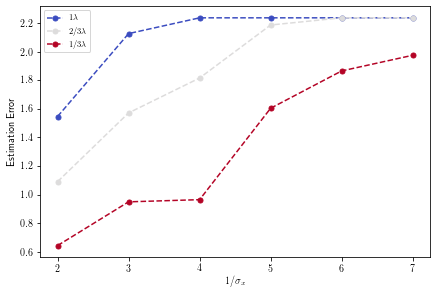

In [155]:
print("Figure 1 for Lasso:")
fig,ax=plt.subplots()
label=[]
n=3
lmbda=np.array(('1','2/3','1/3'))
inv_sigma=np.array((2,3,4,5,6,7))
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, n)])
for k in range(n):
    ax.plot(inv_sigma,l2[:,k],'--',marker="o",markersize=5)
    label=label+['${}\lambda$ '.format(lmbda[k])]
plt.legend(label,fontsize=8)
plt.tight_layout()
plt.xlabel(r"$1/\sigma_x$")
plt.ylabel(r"Estimation Error")
plt.xticks(np.arange(2,8))
plt.show()

Figure 1 for Lasso:


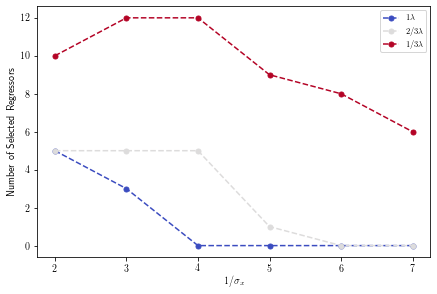

In [160]:
print("Figure 1 for Lasso:")
fig,ax=plt.subplots()
label=[]
n=3
lmbda=np.array(('1','2/3','1/3'))
inv_sigma=np.array((2,3,4,5,6,7))
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, n)])
for k in range(n):
    ax.plot(inv_sigma,cov_num[:,k],'--',marker="o",markersize=5)
    label=label+['${}\lambda$ '.format(lmbda[k])]
plt.legend(label,fontsize=8)
plt.tight_layout()
plt.xlabel(r"$1/\sigma_x$")
plt.ylabel(r"Number of Selected Regressors")
plt.xticks(np.arange(2,8))
plt.show()

In [ ]:
def generateData_paper2(N, p, sigmax): 
  # generate X
    X = random.multivariate_normal(size=N, mean=np.zeros(p), cov=(sigmax**2)*np.identity(p))
  # generate epsilon
    e = np.random.normal(size=N)
    v = np.random.normal(size=N)
  # coefficient vector
    b = np.append(np.ones(5),np.zeros(p-5))
    gamma = np.append(np.ones(5),np.zeros(p-5))
  # generate Y
    Y = X @ b + e
    D = X @ gamma + v

    dat=pd.concat([pd.DataFrame(Y,columns=['Y']),pd.DataFrame(D,columns=['D']),pd.DataFrame(X,columns=[i + j for i, j in zip(['X']*(p),map(str,list(range(1,p+1))))])],axis=1)

  # return dataset
    return(dat)


## Question 3

In [7]:
def sim_generateData(N, rho): 
  # generate X
    X1 = np.random.normal(size=N)
    X2 = rho * X1 + np.sqrt(1-rho**2) * np.random.normal(size=N)
  
  # generate Y
    Y = X1 + (1/np.sqrt(N)) * X2 + np.random.normal(size=N)
    data = {'Y': Y, 'X1': X1, 'X2': X2}
    df = pd.DataFrame (data, columns = ['Y','X1','X2'],index=range(N))

  # return dataset
    return(df)


#### a)

In [6]:
def pretest_estimateCoefficients(dat, alpha):
    # read dimensions
    N = dat.shape[0]
    dn= 1/(N**(1/4))
    X=dat.loc[:, dat.columns.isin(['X1','X2'])]
    mod = sm.OLS(dat.Y, X)
    res = mod.fit()  
    keyDict = {"coefficient","lb","ub","test"}
    output = dict([(key, []) for key in keyDict])
    if np.abs(res.params[1])>dn:
        output['coefficient']=res.params[0]
        output['lb']=res.conf_int(alpha=alpha, cols=None)[0][0]
        output['ub']=res.conf_int(alpha=alpha, cols=None)[1][0]
        output['test']= False
    else:
        X=dat.X1
        mod = sm.OLS(dat.Y, X)
        res = mod.fit()  
        output['coefficient']=res.params[0]
        output['lb']=res.conf_int(alpha=alpha, cols=None)[0][0]
        output['ub']=res.conf_int(alpha=alpha, cols=None)[1][0]
        output['test']= True    
    return output 

  



#### b)

In [7]:
def pretest_simulateCoefficients(N, rho, alpha, S):
    results = pd.DataFrame(columns=("coefficient","lb","ub","test"))
    # perform Monte Carlo simulation
    for k in range(S): 
        dat = sim_generateData(N, rho)
        results=pd.concat([results,pd.DataFrame(pretest_estimateCoefficients(dat, alpha),index=[k])])

    return(results)

# set seed
random.seed(100)
# specify model
# list of N values
N_array = np.array((100, 200, 400, 700, 1000))
# correlation between X's
rho = 0.9
# significance level
alpha = 0.05
# number of Monte Carlo replications
S = 1000

result = pd.DataFrame(columns=("N","coverageProb","shortModelSelectionProb"))
k=0
# perform simulation
for i in N_array:

    # simulate pretest estimators
    results = pretest_simulateCoefficients(N=i, rho=rho, alpha=alpha, S=S)
    # check if each confidence interval contains the true value
    includeTrueValue = (results['lb'] <= 1) * (1 <= results['ub'])
    # return the result
    result=pd.concat([result,pd.DataFrame({"N":i,"coverageProb":includeTrueValue.mean(),"shortModelSelectionProb":results['test'].mean()},index=[k])])
    k=k+1
print(result)



      N  coverageProb  shortModelSelectionProb
0   100         0.845                    0.798
1   200         0.835                    0.861
2   400         0.853                    0.932
3   700         0.846                    0.963
4  1000         0.845                    0.983


### Question 4

In [14]:
def sim_generateData2(N, p, rho):
    # generate X
    X1 = np.random.normal(size=N)
    Xp = (rho / (p-1)) * np.transpose([X1]*(p-1))+ np.sqrt(0.5 * (1-rho**2) / (p-1)) * np.random.normal(size=(N,p-1))
    # generate Y
    # bind Y and X
    Y = X1 + ((1/np.sqrt(N)) * Xp).sum() + np.sqrt(0.5 * (1-rho**2)) * np.random.normal(size=N)
    dat=pd.concat([pd.DataFrame(Y,columns=['Y']),pd.DataFrame(X1,columns=['X1']),pd.DataFrame(Xp,columns=[i + j for i, j in zip(['X']*(p-1),map(str,list(range(2,p+1))))])],axis=1)
    
    return(dat)


#### a)

In [91]:
def doubleLasso_estimateCoefficients_fixedLambda(dat, lmbda, alpha):
  
    # read dimensions
    N = dat.shape[0]
    p = dat.shape[1] - 1
    keyDict = {"coefficient", "lb", "ub", "nreg"}
    output = dict([(key, []) for key in keyDict])
    
    #First Lasso
    lasso1 = lasso_cdg(b_start=np.ones(p-1),y=dat.Y, X=dat[dat.drop(['Y','X1'], axis=1).columns].to_numpy(),lmbda=lmbda[0])
    #List of covariates from the first lasso
    cov1 = dat[dat.drop(['Y'], axis=1).columns].columns[np.nonzero(lasso1["estimate"][-1])[0].tolist()]
    
    #Second Lasso
    lasso2 = lasso_cdg(b_start=np.ones(p-1),y=dat.X1, X=dat[dat.drop(['Y','X1'], axis=1).columns].to_numpy(),lmbda=lmbda[1])
    #List of covariates from the second lasso
    cov2 = dat[dat.drop(['Y'], axis=1).columns].columns[np.nonzero(lasso2["estimate"][-1])[0].tolist()]
    
    #Covariates from first or second lasso 
    X = dat.loc[:, dat.columns.isin(cov1) | dat.columns.isin(cov2)]
    #OLS
    mod = sm.OLS(dat.Y, X)
    res = mod.fit() 
    output['coefficient']=res.params[0]
    output['lb']=res.conf_int(alpha=alpha, cols=None)[0][0]
    output['ub']=res.conf_int(alpha=alpha, cols=None)[1][0]
    output['nreg']=res.params.shape[0]-1
    
    return output
    


#### b)

In [92]:
def doubleLasso_simulateCoefficients_fixedLambda(N, p, rho, lmbda, alpha, S):
  
    # prepare storage space
    results = pd.DataFrame(columns=("coefficient","lb","ub","nreg"))

  
    # perform Monte Carlo simulation
    for k in range(S):
        dat = sim_generateData2(N, p, rho)
        results=pd.concat([results,pd.DataFrame(doubleLasso_estimateCoefficients_fixedLambda(dat, lmbda, alpha),index=[k])])

  
    return(results)



# set seed
random.seed(100)

# specify model
# list of N values
N_array = np.array((100, 200, 400, 700, 1000))
# number of regressors
p = 3
# correlation between X's
rho = 0.9
# lasso penalty multipliers
lmbda = np.array((0.7, 0.7))
# significance level
alpha = 0.05
# number of Monte Carlo replications
S = 1000

result = pd.DataFrame(columns=("N","coverageProb","meanAdditionalRegressors"))
k=0
# perform simulation
for i in N_array:

    # simulate pretest estimators
    results = doubleLasso_simulateCoefficients_fixedLambda(N=i, p=p, rho=rho, lmbda=lmbda, alpha=alpha, S=S)
    # check if each confidence interval contains the true value
    includeTrueValue = (results['lb'] <= 1) * (1 <= results['ub'])
    # return the result
    result=pd.concat([result,pd.DataFrame({"N":i,"coverageProb":includeTrueValue.mean(),"meanAdditionalRegressors":results['nreg'].mean()},index=[k])])
    k=k+1
print(result)


      N  coverageProb  shortModelSelectionProb
0   100         0.944                    1.956
1   200         0.951                    1.996
2   400         0.949                    2.000
3   700         0.957                    2.000
4  1000         0.963                    2.000


#### c)

In [ ]:
def doubleLasso_estimateCoefficients_cvLambda(dat, alpha):
 
    # read dimensions
    N = dat.shape[0]
    p = dat.shape[1] - 1
  
    #First Lasso
    lasso1 = lasso_cdg_kfold(b_start=np.ones(p-1),y=dat.Y, X=dat[dat.drop(['Y','X1'], axis=1).columns].to_numpy())
    #List of covariates from the first lasso
    cov1 = dat[dat.drop(['Y'], axis=1).columns].columns[np.nonzero(lasso1["estimate"][-1])[0].tolist()]
    
    #Second Lasso
    lasso2 = lasso_cdg_kfold(b_start=np.ones(p-1),y=dat.X1, X=dat[dat.drop(['Y','X1'], axis=1).columns].to_numpy())
    #List of covariates from the second lasso
    cov2 = dat[dat.drop(['Y'], axis=1).columns].columns[np.nonzero(lasso2["estimate"][-1])[0].tolist()]
    
    #Covariates from first or second lasso 
    X = dat.loc[:, dat.columns.isin(cov1) | dat.columns.isin(cov2)]
    #OLS
    mod = sm.OLS(dat.Y, X)
    res = mod.fit() 
    output['coefficient']=res.params[0]
    output['lb']=res.conf_int(alpha=alpha, cols=None)[0][0]
    output['ub']=res.conf_int(alpha=alpha, cols=None)[1][0]
    output['nreg']=res.params.shape[0]-1
    
    return output
  


#### d)

In [ ]:
def doubleLasso_simulateCoefficients_cvLambda(N, p, rho, alpha, S):
  
    # prepare storage space
    results = pd.DataFrame(columns=("coefficient","lb","ub","nreg"))

  
    # perform Monte Carlo simulation
    for k in range(S):
        dat = sim_generateData2(N, p, rho)
        results=pd.concat([results,pd.DataFrame(doubleLasso_estimateCoefficients_cvLambda(dat, lmbda, alpha),index=[k])])

  
    return(results)



# set seed
random.seed(100)

# specify model
# list of N values
N_array = np.array((100, 200, 400, 700, 1000))
# number of regressors
 p = 3
# correlation between X's
rho = 0.9
# significance level
alpha = 0.05
# number of Monte Carlo replications
S = 1000

result = pd.DataFrame(columns=("N","coverageProb","meanAdditionalRegressors"))
k=0
# perform simulation
for i in N_array:

    # simulate pretest estimators
    results = doubleLasso_simulateCoefficients_cvLambda(N=i, p=p, rho=rho, alpha=alpha, S=S)
    # check if each confidence interval contains the true value
    includeTrueValue = (results['lb'] <= 1) * (1 <= results['ub'])
    # return the result
    result=pd.concat([result,pd.DataFrame({"N":i,"coverageProb":includeTrueValue.mean(),"meanAdditionalRegressors":results['nreg'].mean()},index=[k])])
    k=k+1
print(result)
